# classification-14

## What's new:

1- [2 2 2 2 2 2 2 2 2 2]

https://claude.ai/chat/da62b3bd-a30f-4e09-8d0b-552a61d94d97

v-7

## next step:

1-


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, TimeDistributed, Lambda, RepeatVector, Dropout, \
    BatchNormalization
from tensorflow.keras import Input, layers, models, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, find_peaks, peak_prominences
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight


2025-11-21 10:51:22.975284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763709682.998910    6892 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763709683.005587    6892 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [3]:
df.shape

(179856, 10)

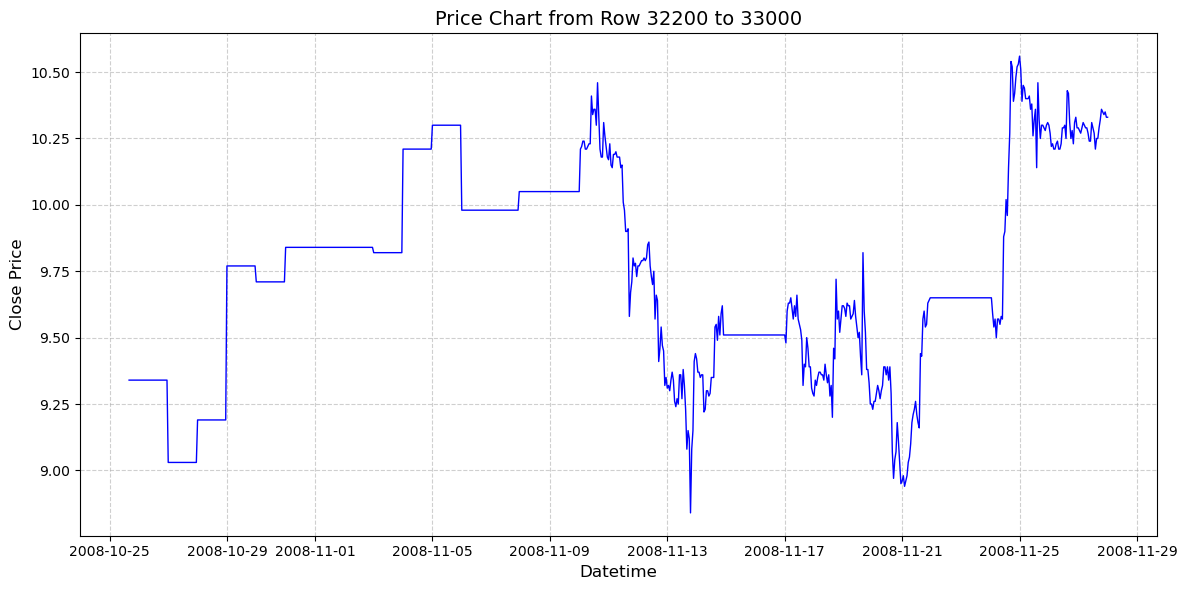

In [4]:
# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [6]:
def label_reversal_points(
        close,
        high=None,
        low=None,
        smoothing_window=31,
        polyorder=3,
        base_prom_factor=0.02,
        distance=3,
        snap_window=5,
        min_dev_pct=0.0015,  # 0.15% minimum leg size
        min_dev_sigma=2.0,  # >= 2x local abs-return EMA
        vol_window=100,  # EMA window for local volatility
        verbose=False
):
    """
    Label reversal points with improved accuracy.

    Returns labels array of length n where:
    0 = none, 1 = valley, 2 = peak.

    Tips:
    - For best accuracy, pass high/low arrays from your OHLCV.
      Example: label_reversal_points(df['CLOSE'], df['HIGH'], df['LOW'])
    - Tune min_dev_pct / min_dev_sigma to be stricter or looser on swing size.
    """
    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # Interpolate NaNs if any
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # Helper: simple EMA for local abs-return volatility
    def ema(x, span):
        x = np.asarray(x, dtype=float)
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    # Local volatility in price terms via EMA of absolute returns
    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close  # convert to price units

    # Smoothing to get robust candidates
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    # Base prominence threshold
    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    # Candidate peaks/valleys on smoothed
    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    # Prominences for tie-breaking
    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    # Combine
    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i]) if peak_prom.size else 0.0))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i]) if val_prom.size else 0.0))
    candidates.sort(key=lambda x: x[0])

    if not candidates:
        labels = np.zeros(n, dtype=int)
        # still mark edges for completeness
        labels[0] = 1 if close[1] > close[0] else 2
        labels[-1] = 1 if close[-1] > close[-2] else 2
        return labels

    # Enforce alternation (remove weaker when two same-type neighbors)
    def enforce_alternation(ext):
        ext = ext[:]  # list of (idx, typ, prom)
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    # drop the smaller prominence
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # SNAP: move each extreme to the true local extremum on raw close (or HIGH/LOW)
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            if typ == 2:  # peak
                j = np.argmax(np.asarray(high[L:R], dtype=float))
            else:  # valley
                j = np.argmin(np.asarray(low[L:R], dtype=float))
        else:
            if typ == 2:
                j = np.argmax(close[L:R])
            else:
                j = np.argmin(close[L:R])
        return L + int(j)

    snapped = []
    seen_at = {}  # avoid duplicate indices by keeping stronger prominence
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        key = (j, typ)
        if key not in seen_at or pr > seen_at[key][2]:
            seen_at[key] = (j, typ, pr)
    snapped = sorted(seen_at.values(), key=lambda x: x[0])

    # Enforce alternation again after snapping
    snapped = enforce_alternation(snapped)

    # Filter micro-legs using adaptive threshold (min % move and sigma*local_vol)
    pruned = []
    for idx, typ, pr in snapped:
        if not pruned:
            pruned.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = pruned[-1]
        # time spacing
        if idx - prev_idx < distance:
            # keep the more prominent of the two
            if pr > prev_pr:
                pruned[-1] = (idx, typ, pr)
            continue
        leg = abs(close[idx] - close[prev_idx])
        # thresholds at both ends
        thr = max(min_dev_pct * close[prev_idx],
                  min_dev_sigma * max(local_vol_price[prev_idx], 1e-12))
        thr = max(thr, max(min_dev_pct * close[idx],
                           min_dev_sigma * max(local_vol_price[idx], 1e-12)))
        if leg >= thr:
            pruned.append((idx, typ, pr))
        else:
            # too small swing → drop the later point
            continue

    # One more alternation pass (paranoid) and spacing check
    pruned = enforce_alternation(pruned)
    final_ext = []
    for idx, typ, pr in pruned:
        if final_ext and idx - final_ext[-1][0] < distance:
            # keep stronger
            if pr > final_ext[-1][2]:
                final_ext[-1] = (idx, typ, pr)
        else:
            final_ext.append((idx, typ, pr))

    # Build labels
    labels = np.zeros(n, dtype=int)
    for idx, typ, _ in final_ext:
        labels[idx] = typ

    # Mark edges as trend boundaries for continuity
    if labels[0] == 0:
        labels[0] = 1 if close[min(1, n - 1)] > close[0] else 2
    if labels[-1] == 0 and n >= 2:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    if verbose:
        c0 = int((labels == 0).sum())
        c1 = int((labels == 1).sum())
        c2 = int((labels == 2).sum())
        print(f"labels -> 0:{c0}  1:{c1}  2:{c2}  (extrema kept: {len(final_ext)})")

    return labels


In [7]:
# baseline (close-only)
df_model['Label'] = label_reversal_points(df_model['CLOSE'].values, verbose=True)

# inspect counts
print(df_model['Label'].value_counts())

labels -> 0:144229  1:1063  2:1064  (extrema kept: 2125)
Label
0    144229
2      1064
1      1063
Name: count, dtype: int64


In [8]:
# Display label distribution in df_model
label_counts = df_model['Label'].value_counts().sort_index()
label_percentages = (df_model['Label'].value_counts(normalize=True) * 100).sort_index()

print("Label Distribution in df_model:")
print("-" * 40)
for label in sorted(df_model['Label'].unique()):
    count = label_counts[label]
    percentage = label_percentages[label]
    print(f"Class {label}: {count:,} rows ({percentage:.2f}%)")
print("-" * 40)
print(f"Total rows: {len(df_model):,}")


Label Distribution in df_model:
----------------------------------------
Class 0: 144,229 rows (98.55%)
Class 1: 1,063 rows (0.73%)
Class 2: 1,064 rows (0.73%)
----------------------------------------
Total rows: 146,356


In [ ]:
def plot_labeled_candles(df_model, n=1000):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df_model.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



In [ ]:
plot_labeled_candles(df_model)

In [ ]:
# ==========================================
# CONFIGURATION
# ==========================================
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [ ]:
# ==========================================
# DATA PREPARATION FUNCTIONS
# ==========================================

def create_sequences(data, labels, window_size, forecast_horizon):
    """
    Create sequences for training/validation.

    Returns:
    - X: shape (n_samples, window_size, n_features)
    - y: shape (n_samples, forecast_horizon, 1) - class labels for each forecast step
    """
    X, y = [], []

    for i in range(len(data) - window_size - forecast_horizon + 1):
        # Input: window_size candles
        X.append(data[i:i + window_size])

        # Output: next forecast_horizon labels
        y.append(labels[i + window_size:i + window_size + forecast_horizon])

    return np.array(X), np.array(y)


def prepare_data(df_model):
    """
    Prepare training data with proper scaling and sequence generation.
    """
    print("\n[DATA PREPARATION]")
    print(f"Total rows in df_model: {len(df_model)}")

    # Extract features and labels
    feature_data = df_model[FEATURES].values
    label_data = df_model['Label'].values

    # Scale features using RobustScaler (handles outliers better for financial data)
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(feature_data)

    # Create sequences
    X, y = create_sequences(scaled_features, label_data, WINDOW_SIZE, FORECAST_HORIZON)

    print(f"Sequence shape X: {X.shape}")  # (n_samples, 60, 5)
    print(f"Sequence shape y: {y.shape}")  # (n_samples, 10)

    # Analyze class distribution
    y_flat = y.flatten()
    unique, counts = np.unique(y_flat, return_counts=True)
    print("\nClass distribution in sequences:")
    for cls, cnt in zip(unique, counts):
        print(f"  Class {int(cls)}: {cnt:,} ({cnt / len(y_flat) * 100:.2f}%)")

    # Split into train/validation (80/20)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
    )

    print(f"\nTrain samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    return X_train, X_val, y_train, y_val, scaler


In [ ]:
# ==========================================
# MODEL ARCHITECTURE
# ==========================================
def build_model(input_shape, forecast_horizon, class_weights=None):
    """
    Build a Bidirectional LSTM model with attention mechanism for
    sequence-to-sequence classification.

    Architecture:
    - Bidirectional LSTM layers to capture temporal patterns
    - Attention mechanism to focus on important time steps
    - TimeDistributed Dense layers for per-step classification
    - Dropout for regularization
    """
    inputs = layers.Input(shape=input_shape, name='input_sequence')

    # First Bidirectional LSTM layer (returns sequences)
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        name='bilstm_1'
    )(inputs)
    x = layers.LayerNormalization()(x)

    # Second Bidirectional LSTM layer (returns sequences)
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        name='bilstm_2'
    )(x)
    x = layers.LayerNormalization()(x)

    # Extract the last window_size representations
    # We'll use the final hidden state to initialize forecast decoder
    encoder_output = layers.GlobalAveragePooling1D()(x)  # (batch, 128)

    # Repeat for forecast_horizon steps
    decoder_input = layers.RepeatVector(forecast_horizon)(encoder_output)

    # Decoder LSTM for generating forecast sequence
    decoder = layers.LSTM(64, return_sequences=True, dropout=0.2, name='decoder_lstm')(decoder_input)
    decoder = layers.LayerNormalization()(decoder)

    # TimeDistributed classification for each forecast step
    # Each of the 10 forecast steps gets independent 3-class prediction
    output = layers.TimeDistributed(
        layers.Dense(32, activation='relu'),
        name='td_dense_1'
    )(decoder)
    output = layers.Dropout(0.3)(output)

    output = layers.TimeDistributed(
        layers.Dense(16, activation='relu'),
        name='td_dense_2'
    )(output)

    # Final classification layer (3 classes: 0, 1, 2)
    output = layers.TimeDistributed(
        layers.Dense(3, activation='softmax'),
        name='forecast_output'
    )(output)

    model = Model(inputs=inputs, outputs=output, name='reversal_classifier')

    # Use focal loss approach by modifying the loss
    # This helps with extreme class imbalance
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',  # y is integer labels
        metrics=['accuracy',
                 keras.metrics.SparseTopKCategoricalAccuracy(k=2, name='top2_acc')]
    )

    return model


In [ ]:
# ==========================================
# MODEL TRAINING SECTION
# ==========================================

print("\n" + "=" * 60)
print("MODEL TRAINING")
print("=" * 60)

# Prepare data
X_train, X_val, y_train, y_val, scaler = prepare_data(df_model)

# Build model
model = build_model(
    input_shape=(WINDOW_SIZE, len(FEATURES)),
    forecast_horizon=FORECAST_HORIZON,
)

print("\n[MODEL ARCHITECTURE]")
model.summary()


In [ ]:

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Create sample weights for training
# Shape must be (n_samples, forecast_horizon) to match y_train shape
# Apply MUCH higher weights to reversal points to make them stand out
sample_weights = np.ones_like(y_train, dtype=np.float32)

for i in range(len(y_train)):
    for j in range(FORECAST_HORIZON):
        label = int(y_train[i, j])
        if label == 0:
            sample_weights[i, j] = 0.1  # Lower weight for no-signal
        elif label == 1:
            sample_weights[i, j] = 10.0  # Very high weight for buy signals
        elif label == 2:
            sample_weights[i, j] = 10.0  # Very high weight for sell signals

print(f"\nSample weights shape: {sample_weights.shape}")
print(
    f"Sample weights - min: {sample_weights.min():.2f}, max: {sample_weights.max():.2f}, mean: {sample_weights.mean():.2f}")

print("\n[TRAINING]")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    sample_weight=sample_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n[TRAINING COMPLETE]")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")


In [ ]:
# Evaluate class-wise performance on validation set
y_val_pred_probs = model.predict(X_val, verbose=0)
y_val_pred = np.argmax(y_val_pred_probs, axis=-1)

print("\n[VALIDATION PERFORMANCE]")
y_val_flat = y_val.flatten()
y_val_pred_flat = y_val_pred.flatten()

for cls in [0, 1, 2]:
    mask = y_val_flat == cls
    if mask.sum() > 0:
        acc = (y_val_pred_flat[mask] == cls).mean()
        print(f"Class {cls} accuracy: {acc:.4f} ({mask.sum()} samples)")

In [ ]:
# ==========================================
# POST-PROCESSING FUNCTIONS FOR REALISTIC PREDICTIONS
# ==========================================
def apply_reversal_filters(pred_probs, min_signals=1, max_signals=2):
    """
    Apply filtering to ensure between min_signals and max_signals reversal points are predicted.

    Parameters:
    - pred_probs: (forecast_horizon, 3) array of class probabilities
    - min_signals: minimum number of reversal signals to output (default: 1)
    - max_signals: maximum number of reversal signals allowed in forecast window (default: 2)

    Returns:
    - filtered_classes: (forecast_horizon,) array of filtered predictions
    """
    filtered_classes = np.zeros(len(pred_probs), dtype=int)

    # Strategy: Find the most confident reversal predictions (class 1 or 2)
    # by looking at how much stronger they are compared to class 0

    reversal_candidates = []

    for i in range(len(pred_probs)):
        prob_0 = pred_probs[i, 0]
        prob_1 = pred_probs[i, 1]
        prob_2 = pred_probs[i, 2]

        # Calculate reversal strength for buy signal (class 1)
        if prob_1 > prob_0:
            strength_1 = prob_1 - prob_0  # How much stronger buy is than no-signal
            reversal_candidates.append((i, 1, prob_1, strength_1))

        # Calculate reversal strength for sell signal (class 2)
        if prob_2 > prob_0:
            strength_2 = prob_2 - prob_0  # How much stronger sell is than no-signal
            reversal_candidates.append((i, 2, prob_2, strength_2))

    # Sort by reversal strength (descending)
    reversal_candidates.sort(key=lambda x: x[3], reverse=True)

    # If we have candidates, select between min_signals and max_signals
    if len(reversal_candidates) >= min_signals:
        # Take top max_signals candidates
        selected = reversal_candidates[:max_signals]
    elif len(reversal_candidates) > 0:
        # We have some candidates but less than min_signals
        # Take all available candidates
        selected = reversal_candidates
    else:
        # No reversal candidates found (all probabilities favor class 0)
        # Force selection of the timestep with highest non-zero probability
        best_reversal_idx = -1
        best_reversal_prob = 0
        best_reversal_class = 1

        for i in range(len(pred_probs)):
            max_rev_prob = max(pred_probs[i, 1], pred_probs[i, 2])
            if max_rev_prob > best_reversal_prob:
                best_reversal_prob = max_rev_prob
                best_reversal_idx = i
                best_reversal_class = 1 if pred_probs[i, 1] > pred_probs[i, 2] else 2

        if best_reversal_idx >= 0:
            selected = [(best_reversal_idx, best_reversal_class, best_reversal_prob, 0)]
        else:
            selected = []

    # Apply the selected reversals
    for idx, cls, prob, strength in selected:
        filtered_classes[idx] = cls

    return filtered_classes


def temporal_consistency_check(pred_classes):
    """
    Ensure temporal consistency - no immediate contradictions like buy followed by sell.
    """
    filtered = pred_classes.copy()

    for i in range(len(filtered) - 1):
        current = filtered[i]
        next_sig = filtered[i + 1]

        # If buy (1) is immediately followed by sell (2) or vice versa, keep only the first
        if current == 1 and next_sig == 2:
            filtered[i + 1] = 0
        elif current == 2 and next_sig == 1:
            filtered[i + 1] = 0

    return filtered


In [ ]:
# ==========================================
# PREDICTION SECTION
# ==========================================
# ==========================================
# PREDICTION SECTION
# ==========================================

print("\n" + "=" * 60)
print("PREDICTION ON UNSEEN DATA")
print("=" * 60)

# Given time for prediction
given_time = "2025.08.13 21:00:00"
print(f"\nGiven time (last candle): {given_time}")

# Find the index of given_time in df (unseen data)
# Assuming df has same structure as df_model with DATETIME column
try:
    # Convert given_time to the format in your df
    given_datetime = pd.to_datetime(given_time)

    # Find the index in df where DATETIME matches given_time
    idx = df[df['DATETIME'] == given_datetime].index[0]
    print(f"Found given_time at index: {idx}")

    # Extract the 60 candles ENDING at given_time (inclusive)
    # This means indices [idx-59:idx+1]
    if idx < WINDOW_SIZE - 1:
        raise ValueError(f"Not enough history: need {WINDOW_SIZE} candles before given_time")

    start_idx = idx - WINDOW_SIZE + 1
    end_idx = idx + 1

    input_df = df.iloc[start_idx:end_idx]
    print(f"Input window: {input_df['DATETIME'].iloc[0]} to {input_df['DATETIME'].iloc[-1]}")
    print(f"Input window shape: {input_df.shape}")

    # Extract and scale features
    input_features = input_df[FEATURES].values
    input_scaled = scaler.transform(input_features)

    # Reshape for model: (1, WINDOW_SIZE, n_features)
    X_pred = input_scaled.reshape(1, WINDOW_SIZE, len(FEATURES))

    # Predict
    print("\n[RUNNING PREDICTION]")
    pred_probs = model.predict(X_pred, verbose=0)  # Shape: (1, 10, 3)

    # Raw predictions (before filtering)
    raw_pred_classes = np.argmax(pred_probs[0], axis=-1)
    print(f"\nRaw Predicted Classes (before filtering):")
    print(raw_pred_classes)

    # Apply post-processing filters for realistic reversal detection
    # min_signals=1 ensures at least 1 reversal, max_signals=2 caps at 2 reversals
    filtered_classes = apply_reversal_filters(
        pred_probs[0],
        min_signals=1,  # At least 1 reversal signal
        max_signals=2  # At most 2 reversal signals
    )

    # Apply temporal consistency check
    pred_classes = temporal_consistency_check(filtered_classes)

    print(f"\nFiltered Predicted Classes (0=no signal, 1=buy, 2=sell):")
    print(pred_classes)

    # Create forecast datetimes (next 10 hours after given_time)
    forecast_datetimes = pd.date_range(
        start=given_datetime + pd.Timedelta(hours=1),
        periods=FORECAST_HORIZON,
        freq='h'
    )

    # Build predicted_df
    predicted_df = pd.DataFrame({
        'DATETIME': forecast_datetimes,
        'forecast_class': pred_classes,
        'prob_0': pred_probs[0, :, 0],
        'prob_1': pred_probs[0, :, 1],
        'prob_2': pred_probs[0, :, 2]
    })

    # Add confidence metric (max probability)
    predicted_df['confidence'] = predicted_df[['prob_0', 'prob_1', 'prob_2']].max(axis=1)

    print("\n" + "=" * 60)
    print("PREDICTION RESULTS")
    print("=" * 60)
    print(f"\nForecast for next {FORECAST_HORIZON} hours after {given_time}:")
    print(predicted_df.to_string(index=False))

    # Summary statistics
    reversal_count = (pred_classes != 0).sum()
    buy_signals = (pred_classes == 1).sum()
    sell_signals = (pred_classes == 2).sum()

    print(f"\n[PREDICTION SUMMARY]")
    print(f"No signal (0): {FORECAST_HORIZON - reversal_count} hours")
    print(f"Buy signals (1): {buy_signals} hours")
    print(f"Sell signals (2): {sell_signals} hours")
    print(f"Average confidence: {predicted_df['confidence'].mean():.4f}")

    # Show which hours have signals
    if reversal_count > 0:
        signal_hours = predicted_df[predicted_df['forecast_class'] != 0][['DATETIME', 'forecast_class', 'confidence']]
        print(f"\nReversal signals detected:")
        print(signal_hours.to_string(index=False))
    else:
        print("\nNo reversal signals detected in forecast window.")

except Exception as e:
    print(f"\nERROR during prediction: {e}")
    print("\nCreating sample predicted_df structure for reference:")

    # Create sample output structure
    given_datetime = pd.to_datetime(given_time)
    forecast_datetimes = pd.date_range(
        start=given_datetime + pd.Timedelta(hours=1),
        periods=FORECAST_HORIZON,
        freq='H'
    )

    predicted_df = pd.DataFrame({
        'DATETIME': forecast_datetimes,
        'forecast_class': np.zeros(FORECAST_HORIZON, dtype=int),
        'prob_0': np.ones(FORECAST_HORIZON) * 0.9,
        'prob_1': np.ones(FORECAST_HORIZON) * 0.05,
        'prob_2': np.ones(FORECAST_HORIZON) * 0.05,
        'confidence': np.ones(FORECAST_HORIZON) * 0.9
    })

    print(predicted_df.to_string(index=False))

# Final output (as requested)
predicted_df


In [ ]:
input_df

In [ ]:
predicted_df

# plot section

In [ ]:
# --------------------------
# === Visualization Block ===
# --------------------------

historical_df = input_df.tail(4).copy()


In [ ]:
historical_df

In [ ]:
# --- 2. Actual future 10 candles  ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = idx + 1
actual_future_end = idx + FORECAST_HORIZON + 1
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()


In [ ]:
actual_future_df

In [ ]:
# --- 3. Create predicted_df (forecast for next 10 hours) ---
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=FORECAST_HORIZON,
    freq='h'
)

# --- 4. Add text labels for clarity ---
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



In [ ]:
# --- 6. Import your plotting utility ---

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [ ]:
# 11- Save Model

from datetime import datetime
import os

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs('saved_models', exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
print(f"\n[SAVING MODEL]")
model.save(model_path)
print(f"Model saved to: {model_path}")

# 11-4 Save scaler (IMPORTANT - needed for predictions!)
import joblib

scaler_path = os.path.join('saved_models', f'scaler_{timestamp}.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# 11-5 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)
print(f"Training history saved")

# 11-6 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-7 Save accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_accuracy.png'))
plt.close()

# 11-8 Evaluate on validation set
# model.evaluate returns [loss, accuracy, top2_acc] - 3 values!
eval_results = model.evaluate(X_val, y_val, verbose=0)
final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = eval_results[0]
final_val_acc = eval_results[1]
final_val_top2_acc = eval_results[2]

# 11-9 Save model summary and performance metrics
summary_path = os.path.join(log_dir, 'model_log.txt')
with open(summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('\n')
    f.write('=' * 60 + '\n')
    f.write('TRAINING RESULTS\n')
    f.write('=' * 60 + '\n')
    f.write(f'Final Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Training Accuracy: {final_train_acc:.6f}\n')
    f.write(f'Final Validation Loss: {final_val_loss:.6f}\n')
    f.write(f'Final Validation Accuracy: {final_val_acc:.6f}\n')
    f.write(f'Final Validation Top-2 Accuracy: {final_val_top2_acc:.6f}\n')
    f.write('\n')
    f.write('=' * 60 + '\n')
    f.write('MODEL FILES\n')
    f.write('=' * 60 + '\n')
    f.write(f'Model: {model_path}\n')
    f.write(f'Scaler: {scaler_path}\n')
    f.write(f'Timestamp: {timestamp}\n')

print(f"Model summary and metrics saved to: {summary_path}")
print(f"\n[SAVE COMPLETE]")
print(f"All files saved in: saved_models/")

In [ ]:
model_path = 'saved_models/model_20251116_190307.keras'
model = keras.models.load_model(
    model_path,
    safe_mode=False
)